# 🧪 **Simulation Tutorial**

This tutorial demonstrates how to simulate synthetic panel data with **trigger-based outbreaks** and then apply `OptimalBundleRL` to forecast outcomes for a target unit.

## ⚙️ **Simulation Details**

We simulate panel data for 3 units (A, B, C) from 1970 to 2035, each with an outcome variable $y$ and one key predictor $x$.
- `x`: a unit-specific AR(1) feature. When its lag $x_{t-1}$ exceeds a threshold, it triggers an outbreak shock in $y_{t}$.
- `Unit A (target)`: experiences outbreaks triggered by high $x_{t-1}$ in 2006–2008 (**calibration**) and 2028–2030 (**test**).
- `Unit B (uninformative donor)`: its $x$ rarely crosses the threshold, providing little predictive power.
- `Unit C (informative donor)`: has the same trigger mechanism in 1992–1994 (**training**) and 2003–2005 (**calibration**).

In [1]:
import numpy as np
import pandas as pd

# ----------------------------
# Simulation configuration
# ----------------------------
np.random.seed(42)

years = np.arange(1970, 2036)     # 1970..2035
n_years = len(years)
units = ['A', 'B', 'C']

# DGP parameters
rho = 0.8                 # AR(1) for y
beta_x = 0.6              # baseline effect of x on y
sigma_eps = 0.5
phi_x = 0.6               # AR(1) for x
sigma_x = 0.6             # x innovations
shock_size = 3.0          # outbreak shock magnitude
theta = 1.2               # trigger threshold for x_{t-1}
pulse = 2.0               # size of x pulses to ensure threshold crossings

# ----------------------------
# Explicit windows
# ----------------------------
train_years = np.arange(1990, 2001)    # 1990–2000
cal_years   = np.arange(2001, 2011)    # 2001–2010
test_years  = np.arange(2025, 2033)    # 2025–2032

train_periods = pd.to_datetime(pd.Series(train_years), format="%Y")
calibration_periods = pd.to_datetime(pd.Series(cal_years), format="%Y")
testing_periods = pd.to_datetime(pd.Series(test_years), format="%Y")

# ----------------------------
# Triggerable sub-windows (where we WANT frequent triggers)
# ----------------------------
# A: one triggerable block in CAL and one in TEST
A_cal_blocks  = [(2006, 2008)]
A_test_blocks = [(2028, 2030)]

# C: one triggerable block in TRAIN and one in CAL
C_train_blocks = [(1992, 1994)]
C_cal_blocks   = [(2003, 2005)]

def in_any_interval(y, intervals):
    if not intervals:
        return False
    return any(a <= y <= b for (a, b) in intervals)

def inject_pulses(x, yrs, blocks, magnitude):
    """Add pulses to x so x_{t-1} will exceed threshold during `blocks`."""
    x = x.copy()
    y_to_idx = {y:i for i, y in enumerate(yrs)}
    for a, b in blocks:
        for y in range(a, b + 1):
            t = y_to_idx.get(y - 1, None)  # we want x_{t-1} to be high when evaluating year y
            if t is not None and 0 <= t < len(x):
                x[t] += magnitude
    return x

# ----------------------------
# Simulate panel
# ----------------------------
rows = []

# Base AR(1) x paths per unit
x_paths = {}
for unit in units:
    x = np.zeros(n_years)
    x[0] = np.random.normal()
    for t in range(1, n_years):
        x[t] = phi_x * x[t-1] + np.random.normal(scale=sigma_x)
    x_paths[unit] = x

# Add pulses so specific units cross the trigger in chosen windows
x_paths['A'] = inject_pulses(x_paths['A'], years, A_cal_blocks + A_test_blocks, pulse)
x_paths['C'] = inject_pulses(x_paths['C'], years, C_train_blocks + C_cal_blocks, pulse)
# B gets no pulses -> remains mostly below threshold (uninformative)

for unit in units:
    alpha = np.random.normal()
    eps   = np.random.normal(scale=sigma_eps, size=n_years)
    x     = x_paths[unit]

    # Initialize y
    y = np.zeros(n_years)
    y[0] = alpha + beta_x * x[0] + eps[0]

    for t in range(1, n_years):
        year_t = years[t]

        # assign window label
        if year_t in train_years:
            window = 'train'
        elif year_t in cal_years:
            window = 'cal'
        elif year_t in test_years:
            window = 'test'
        else:
            window = None

        # outbreak trigger via x_{t-1} > theta in designated blocks
        delta = 0.0
        if unit == 'A':
            if (in_any_interval(year_t, A_cal_blocks) or in_any_interval(year_t, A_test_blocks)) and (x[t-1] > theta):
                delta = shock_size
        elif unit == 'C':
            if (in_any_interval(year_t, C_train_blocks) or in_any_interval(year_t, C_cal_blocks)) and (x[t-1] > theta):
                delta = shock_size
        else:
            # B has no designated trigger blocks; (x[t-1] > theta) is rare -> mostly no outbreaks
            delta = 0.0

        # DGP for y
        y[t] = alpha + rho * y[t-1] + beta_x * x[t] + delta + eps[t]

        rows.append({
            'unit': unit,
            'year': year_t,
            'y': y[t],
            'y_lag': y[t-1],
            'x': x[t],
            'x_lag': x[t-1],
            'delta': delta,
            'window': window
        })

# Build DataFrame
df_sim = pd.DataFrame(rows)
df_sim['year'] = pd.to_datetime(df_sim['year'], format='%Y')
df_sim

,unit,year,y,y_lag,x,x_lag,delta,window
0,A,1971-01-01,0.193946,-0.215248,0.215070,0.496714,0.0,None
1,A,1972-01-01,0.804351,0.193946,0.517655,0.215070,0.0,None
2,A,1973-01-01,1.977862,0.804351,1.224411,0.517655,0.0,None
3,A,1974-01-01,2.523892,1.977862,0.594155,1.224411,0.0,None
4,A,1975-01-01,1.518094,2.523892,0.216011,0.594155,0.0,None
...,...,...,...,...,...,...,...,...
190,C,2031-01-01,0.644230,0.489761,-0.688506,0.098229,0.0,test
191,C,2032-01-01,0.171084,0.644230,-0.309195,-0.688506,0.0,test
192,C,2033-01-01,-0.616492,0.171084,0.045673,-0.309195,0.0,None
193,C,2034-01-01,-0.042199,-0.616492,-0.502910,0.045673,0.0,None


### A plot of `y` by unit reveals these patterns visually:

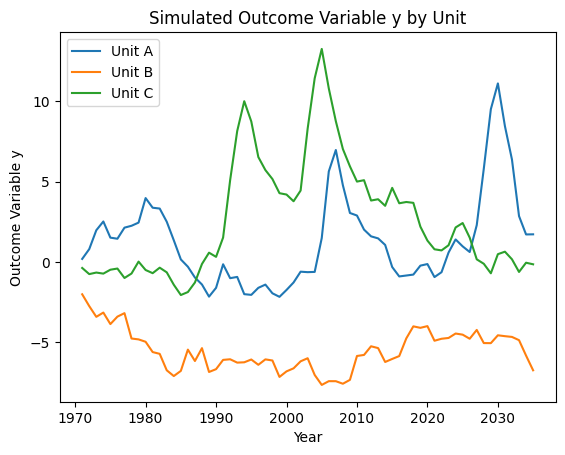

In [2]:
# Plot "y" for each unit
import matplotlib.pyplot as plt
for unit in units:
    subset = df_sim[df_sim['unit'] == unit]
    plt.plot(subset['year'], subset['y'], label=f'Unit {unit}')
plt.title('Simulated Outcome Variable y by Unit')
plt.xlabel('Year')
plt.ylabel('Outcome Variable y')
plt.legend()
plt.show()

## 🎯 Applying OptimalPanel

Once the panel is simulated, we initialize and prepare the **RL optimizer**:

In [3]:
from OptimalPanel import OptimalBundleRL

calibration_periods = pd.date_range(start="2000-01-01", end="2020-01-01", freq="YS")
testing_periods     = pd.date_range(start="2021-01-01", end="2035-01-01", freq="YS")
    
rl = OptimalBundleRL(
    df=df_sim[['unit', 'year', 'y', 'y_lag', 'x_lag']],
    unit_col='unit',
    time_col='year',
    target_col='y',
    feature_cols=['y_lag', 'x_lag'],
    target_unit='A',
    calibration_periods=calibration_periods,
    testing_periods=testing_periods,
)


**OptimalPanel Package — Reinforcement Learning for Panel Forecasting**  
Developed by [Renato Vassallo](https://www.linkedin.com/in/renatovassallo) — Institute for Economic Analysis (IAE-CSIC)  
Version 0.1 — October 2025  

---

**Model Overview**  
- **Framework**: Reinforcement Learning (RL) for optimal donor bundle selection  
- **Device**: cpu  
- **Learning Rate**: 0.001  

---

**Panel Structure**  
- **Unit Column**: `unit`  
- **Time Column**: `year`  
- **Time Frequency**: YS-JAN  
- **Target Unit**: `A`  
- **Outcome Variable**: `y`  
- **Feature Variables**: y_lag, x_lag  

---

**Temporal Setup**  
- **Train Period**: 1971-01-01 → 1999-01-01  (29 obs)  
- **Calib Period**: 2000-01-01 → 2020-01-01  (21 obs)  
- **Test Period**: 2021-01-01 → 2035-01-01  (15 obs)  
---


This defines a **forecasting experiment for Unit A**, where the RL Policy explores different donor combinations (Units B and C) to improve predictive accuracy during the **calibration period** (2000–2020).

- Once the **optimal donor bundle** is learned, the model performs a _rolling out-of-sample forecast_ over the testing period (2021–2035) using the fixed optimal bundle identified in calibration.
- Forecast performance is compared against standard benchmarks: an AR(1) model on the target only, a Random Forest on the target + feature $x_{t-1}$ (Solo RF), and a Random Forest using all donor units (Full Panel RF).

In [4]:
# Initial similarity vector
initial_similarities = rl.compute_similarities()


Target: A — Initial similarities from TRAIN window (< 2000-01-01)
  C: 0.5813
  B: 0.4188


In [5]:
total_epochs = 200

rl.train(n_epochs=total_epochs, save=False)
rl.print_top_bundles(top_k=1)


Starting RL training with rolling calibration windows...
Epoch 0 — Avg MSE (cal): 1.2340 | Bundle Size: 1
Epoch 100 — Avg MSE (cal): 1.2428 | Bundle Size: 2

Benchmark MSEs on TEST window:
- Benchmark MSE (AR(1))       : 4.20253696897622
- Benchmark MSE (Target only) : 3.5937269432619074
- Benchmark MSE (Full panel)  : 1.556246041466117
- Benchmark MSE (Fixed bundle): 1.4821234139605257
- Training completed without saving results.

Top 1 Bundles by MSE:
1. Epoch   0 — MSE: 1.2340, Bundle: ['C']


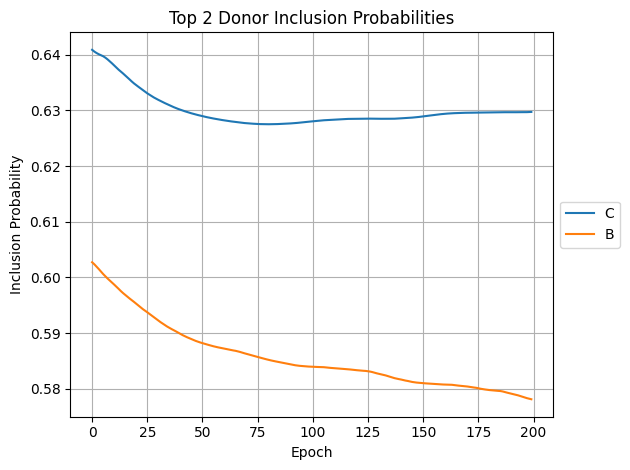

In [6]:
rl.plot_donor_probs(top_n=2)

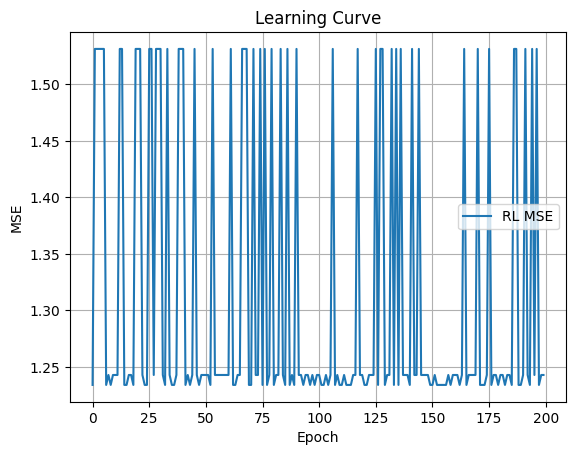

In [7]:
rl.plot_learning_curve()